
<div align=left>
    
<img src="images/logo.jfif" alt="Italian Trulli">
<h4 align=right>April 10, 2020</h4>
</div>

<h1 align=center>IBM Data Science Professional Certification Capstone project</h1>

<h2 align=center> Guatemala shopping mall classification</h2>

<h4 align=right>Solution developed by Javier Navarro:</h4>
<h4 align=right>javierestuardonavarro@gmail.com</h4>


## Introduction

Given the current situation of the Covid-19 health emergency in the Guatemalan territory, problems are experienced regarding the supply of basic supplies, one of these problems is the high crowding of people in supermarkets, even though quarantine is in force, this implies great risks for containment of the outbreak, but not in all supermarkets crowds are observed, that is why as a data scientist I have the objective of making a classification by municipalities (regions) in relation to the provision of supermarkets, this to provide a broad paronama for the Correct distribution of citizens, that is, after carrying out the analysis, the areas with the least amount of supermarkets can be identified, which implies a greater probability of crowding.


## Table of Contents

1. <a href="#Data">Data</a>  
2. <a href="#Methodology">Methodology</a>  
3. <a href="#Results">Results</a>  
4. <a href="#Discussion">Discussion</a>  
5. <a href="#Conclusions">Conclusions</a>  

## Data

The data to be used is the distribution of municipalities in the department of Guatemala, information provided by the site: https://www.geodatos.net/coordines/guatemala basically it is the triplet <city, latitude, longitude> this data will be preprocessed for validate its integrity and later it will be transformed in such a way that it can allow obtaining information about the nearby supermarkets using the Foursquare API. An example of data provided for a site is the following:


![alt text](images/data.PNG)


## Methodology

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

#### Load dataframe from Wikipedia

First step is scrape the table of postal codes of Canada, use **pandas.read_html**

In [21]:

url = "https://www.geodatos.net/coordenadas/guatemala"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

df = pd.read_html(r.text)[1]
df.head()

,Ciudad,Coordenadas
0,Ciudad de Guatemala,"14.6407204, -90.5132675"
1,Mixco,"14.6333303, -90.6063919"
2,Villa Nueva,"14.5269403, -90.5875015"
3,Petapa,"14.50278, -90.5516663"
4,San Juan Sacatepéquez,"14.7188902, -90.6441727"


#### Pre-processing

##### Guarantee data requirements:

Table should be atomic, and previus data frame contains in a same column two fields, that implies a transform


In [22]:
df.rename(columns={"Ciudad": "Neighborhood"}, inplace=True)
df[['Latitude','Longitude']] = df.Coordenadas.str.split(",",expand=True,)
df['Latitude']=df['Latitude'].astype('float64')
df['Longitude']=df['Longitude'].astype('float64')
df=df.drop('Coordenadas', 1)
df.head()

,Neighborhood,Latitude,Longitude
0,Ciudad de Guatemala,14.64072,-90.513267
1,Mixco,14.63333,-90.606392
2,Villa Nueva,14.52694,-90.587502
3,Petapa,14.50278,-90.551666
4,San Juan Sacatepéquez,14.71889,-90.644173


#### Use geopy library to get the latitude and longitude values of Guatemala.

In [25]:
address = 'Guatemala City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Guatemala are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Guatemala are 14.6222328, -90.5185188.


## 5. Create a map of Guatemala with neighborhoods superimposed on top.

In [139]:
# create map of Toronto using latitude and longitude values
neighborhoods = df
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Define Foursquare Credentials and Version

In [30]:
CLIENT_ID = 'HF53CCXZABRPMDPXY4Z5SCLWKCSZJVZTJ1GQRFIG5TG25AC0' # your Foursquare ID
CLIENT_SECRET = 'JQTXVXRSCAORFRVY00KIBJTNUYIUJC5NKWZAZW4BEE53URMQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HF53CCXZABRPMDPXY4Z5SCLWKCSZJVZTJ1GQRFIG5TG25AC0
CLIENT_SECRET:JQTXVXRSCAORFRVY00KIBJTNUYIUJC5NKWZAZW4BEE53URMQ


#### Define function for get nearby venues

In [119]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Create a new dataframe called *guatemala_venues*.

In [120]:
guatemala_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Ciudad de Guatemala
Mixco
Villa Nueva
Petapa
San Juan Sacatepéquez
Quetzaltenango
Villa Canales
Escuintla
Chinautla
Chimaltenango
Chichicastenango
Huehuetenango
Amatitlán
Totonicapán
Santa Catarina Pinula
Santa Lucía Cotzumalguapa
Puerto Barrios
San Francisco El Alto
Cobán
San José Pinula
San Pedro Ayampuc


#### Let's check the size of the resulting dataframe

In [121]:
print(guatemala_venues.shape)
guatemala_venues.head()

(634, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ciudad de Guatemala,14.64072,-90.513267,Panaderia Berna,14.639136,-90.515013,Bakery
1,Ciudad de Guatemala,14.64072,-90.513267,El Portalito,14.640646,-90.513624,Bar
2,Ciudad de Guatemala,14.64072,-90.513267,Roque Rosito Café Gourmet,14.640127,-90.511779,Café
3,Ciudad de Guatemala,14.64072,-90.513267,El Cafetalito Zona 1,14.637802,-90.512104,Café
4,Ciudad de Guatemala,14.64072,-90.513267,El Adobe,14.639637,-90.512750,Restaurant


#### Unique categories can be curated from all the returned venues and check if the results containg Shopping Mall

In [146]:
print('There are {} uniques categories.'.format(len(guatemala_venues['Venue Category'].unique())))
"Shopping Mall" in guatemala_venues['Venue Category'].unique()

There are 128 uniques categories.


True

#### Analyze each neighborhood

In [123]:
# one hot encoding
guatemala_onehot = pd.get_dummies(guatemala_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
guatemala_onehot['Neighborhood'] = guatemala_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [guatemala_onehot.columns[-1]] + list(guatemala_onehot.columns[:-1])
guatemala_onehot = guatemala_onehot[fixed_columns]
print(guatemala_onehot.shape)
guatemala_onehot.head()

(634, 129)


,Neighborhood,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Campground,Cantonese Restaurant,Chinese Restaurant,Church,City,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Dance Studio,Deli / Bodega,Department Store,Diner,Dumpling Restaurant,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Historic Site,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Other Repair Shop,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Theater,Theme Park Ride / Attraction,Theme Restaurant,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Yoga Studio,Zoo
0,Ciudad de Guatemala,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ciudad de Guatemala,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ciudad de Guatemala,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ciudad de Guatemala,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ciudad de Guatemala,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Group rows by neighborhood

In [125]:
guatemala_grouped = guatemala_onehot.groupby('Neighborhood').mean().reset_index()
print(guatemala_grouped.shape)
guatemala_grouped.head()

(21, 129)


,Neighborhood,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Campground,Cantonese Restaurant,Chinese Restaurant,Church,City,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Dance Studio,Deli / Bodega,Department Store,Diner,Dumpling Restaurant,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Historic Site,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Other Repair Shop,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Theater,Theme Park Ride / Attraction,Theme Restaurant,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Yoga Studio,Zoo
0,Amatitlán,0.0,0.00,0.00,0.00,0.00,0.0,0.055556,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.055556,0.00,0.055556,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.055556,0.00,0.00,0.055556,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.055556,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.055556,0.0,0.000,0.111111,0.055556,0.0,0.000000,0.111111,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.055556,0.00,0.0,0.00
1,Chichicastenango,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.00,0.00,0.20,0.00,0.0,0.00,0.0,0.0,0.0,0.20,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00
2,Chimaltenango,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.125000,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.125,0.250000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00
3,Chinautla,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.

#### Removing all categorys, except Shopping Mall

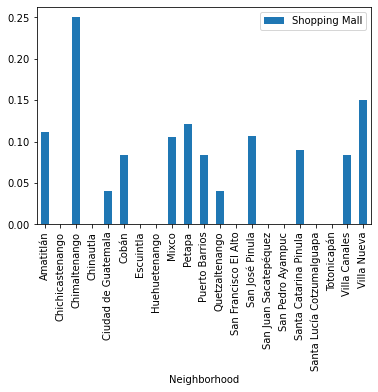

In [157]:
guatemala_mall = guatemala_grouped[["Neighborhood","Shopping Mall"]]

to_plot=guatemala_mall.copy()
to_plot.set_index("Neighborhood",inplace=True)
to_plot.plot(kind='bar')

#### Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters

In [131]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = guatemala_mall.drop('Neighborhood', 1)

# run k-means clusteringz
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


# add clustering labels
guatemala_mall.insert(0, 'Cluster Labels', kmeans.labels_)

guatemala_merged = df.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
guatemala_merged = guatemala_merged.join(guatemala_mall.set_index('Neighborhood'), on='Neighborhood')

guatemala_merged.tail() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,Shopping Mall
16,Puerto Barrios,15.72778,-88.594437,2,0.083333
17,San Francisco El Alto,14.95000,-91.449997,0,0.000000
18,Cobán,15.47083,-90.370827,2,0.083333
19,San José Pinula,14.54611,-90.411392,2,0.106383
20,San Pedro Ayampuc,14.78667,-90.451111,0,0.000000


## Results

In [158]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(guatemala_merged['Latitude'], guatemala_merged['Longitude'], guatemala_merged['Neighborhood'], guatemala_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Save a map as HTML File

In [52]:
map_clusters.save('map_clusters.html')

## Discussion

#### Exploring cluster 0 (lower presence of supermarkets)

In [113]:
guatemala_merged[guatemala_merged['Cluster Labels']==0]

,Neighborhood,Latitude,Longitude,Cluster Labels,Shopping Mall
0,Ciudad de Guatemala,14.64072,-90.513267,0,0.0125
3,Petapa,14.50278,-90.551666,0,0.0000
4,San Juan Sacatepéquez,14.71889,-90.644173,0,0.0000
5,Quetzaltenango,14.83472,-91.518059,0,0.0250
7,Escuintla,14.30500,-90.785004,0,0.0000
8,Chinautla,14.70833,-90.499443,0,0.0000
10,Chichicastenango,14.93333,-91.116669,0,0.0000
11,Huehuetenango,15.31918,-91.472412,0,0.0000
13,Totonicapán,14.91167,-91.361107,0,0.0000
16,Puerto Barrios,15.72778,-88.594437,0,0.0000


#### Exploring cluster 1 (upper presence of supermarkets)

In [137]:
guatemala_merged[guatemala_merged['Cluster Labels']==1]

,Neighborhood,Latitude,Longitude,Cluster Labels,Shopping Mall
9,Chimaltenango,14.66111,-90.819443,1,0.25


#### Exploring cluster 2 (middle presence of supermarkets)

In [138]:
guatemala_merged[guatemala_merged['Cluster Labels']==2]

,Neighborhood,Latitude,Longitude,Cluster Labels,Shopping Mall
1,Mixco,14.63333,-90.606392,2,0.105263
2,Villa Nueva,14.52694,-90.587502,2,0.150000
3,Petapa,14.50278,-90.551666,2,0.121212
6,Villa Canales,14.48139,-90.531670,2,0.083333
12,Amatitlán,14.47740,-90.634888,2,0.111111
14,Santa Catarina Pinula,14.56889,-90.495277,2,0.090000
16,Puerto Barrios,15.72778,-88.594437,2,0.083333
18,Cobán,15.47083,-90.370827,2,0.083333
19,San José Pinula,14.54611,-90.411392,2,0.106383


Before discussing the results obtained, it is important to highlight a couple of considerations. First, it is assumed that the Foursquare API is widely used in my country and that the data obtained provides a broad perspective of various users and is up-to-date. Second, they were only considered shopping centers but they could also be considered supermarkets, as well as neighborhood grocery stores (a small business that is very common in my country).


It is noteworthy that in rural areas, that is, those far from the country's capital, clusters of low number of nearby businesses predominate, so I would recommend implementing government measures to improve the supply system in the countryside.

## Conclusions

- Three clusters were built that represent the low, intermediate or high prevalence of shopping centers in the most common neighborhoods of the country of Guatemala
- It was determined that the further away from the capital you are, the less there are shopping centers and therefore crowds are induced
- The low clusters identified in the capital correspond to areas marked as "red", a relationship could be established between social status and the agglomeration or ignorance of the rules imposed by the government